# Parallel Logistic Regression Classifier on Spark

Author: **Giorgio Polla**  
Date: **27/11/2019**  

Implementation of a Logistic Regression classifier on Spark, with Python.  
The algorithm is tested using cross-validation on the _Spam_ dataset available at https://web.stanford.edu/~hastie/ElemStatLearn/data.html.


### Libraries and constants

Import of the following libraries:  
* `pyspark` to utilize *Spark*;  
* `time` to track the time performance of the implementation;  
* `numpy` to easily operate with number arrays;  
* `random` to provide the random functionalities used in the cross-validation dataset split;  
* `matplotlib` to plot graphs;  
* `sklearn` to easily compute some evaluation metrics.  

Moreover, some operative constants used in the following are defined, and finally the Spark context is intialised.

In [12]:
import pyspark
import time
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from random import randrange
from scipy.interpolate import make_interp_spline
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

FILE_PATH = '../data/spam.txt'
OUT_PATH = '../out/'
IMG_FORMAT = 'png'
N_WORKERS = 8
EPSILON = 1e-10

In [4]:
if 'sc' in locals():
    print('Restart Spark Context')
    sc.stop()
else:
    print('Initialise Spark Context')
    
# conf = SparkConf().setAppName("lol").setMaster("local[8]")
# conf.set('spark.scheduler.mode', 'FAIR')
# conf.set('spark.dynamicAllocation.enabled', 'true')
# conf.set('spark.shuffle.service.enabled', 'true')
# sc = SparkContext(conf=conf) 

sc = pyspark.SparkContext('local[' + str(N_WORKERS) + ']')

Initialise Spark Context


### File reading
The spam dataset is loaded as an RDD, using the `textFile()` function.  
The RDD is then manipulated in order to have each record as a tuple **(X, y)** , where:  
**X** is an array containing the features of the example (57 float numbers);  
**y** is an integer containing the label of the example (0 or 1).  

The result is then quickly tested.

In [5]:
def read_file(file_path, n_workers=N_WORKERS):
    rdd = sc.textFile(file_path, n_workers)
    
    rdd = rdd.map(
        lambda x: (
            np.array([float(el) for el in x[:-1].split()]),
            int(x[-1])
        )
    )
    
    return rdd

In [6]:
rdd = read_file(FILE_PATH)
rdd.take(1)[0][0][56] # test -> 278.0

278.0

### Standardisation
Each row of the RDD is standardised; this is done by first obtaining the mean for each column, then obtaining the standard deviation for them, and finally applying the standardisation formula.  

The result is then again quickly tested.

In [7]:
def standardise(rdd):    
    n_rows = rdd.count()
    
    col_sum = rdd.map(
        lambda x:
            x[0]
    ).reduce(
        lambda x, y:
            x + y
    )
    mean = col_sum / n_rows
    
    variance = rdd.map(
        lambda x: np.square(x[0] - mean)
    ).reduce(
        lambda x, y:
            x + y
    )
    std_dev = np.sqrt(variance / n_rows)
    
    rdd = rdd.map(
        lambda x: (
            (x[0] - mean) /  std_dev,
            x[1]
        )
    )
    
    return rdd

In [8]:
rdd = standardise(rdd)
rdd.first()[0][56] # test -> -0.008724

-0.008724133882501232

### Training
The training phase follows the typical Logistic Regression fashion, with some adjustments to exploit the Spark parallelisation.  
It is worth noting that the notation is consistent, and in particular:  
* **rdd** is an RDD containing the records on which to train the model;
* **x** is a data point feature array (57 float numbers);  
* **y** is a data point label (integer, either 0 or 1);  
* **b** is the regression bias term (float number);  
* **w** is the regression weights array (57 float numbers);  
* **p** is the predicted class probability for of data point (float number between 0 and 1);

In the first section there are the support functions for the proper training phase.  
* `sigmoid()` simply represents the Sigmoid function;  
* `predict_probability()` calculates and returns the predicted class probability **y** for each record, exploting the `sigmoid()` function;  
* `cross_entropy()` is the Cross Entropy function, utilised to obtain the training error of the model;  
* `gradient()` calculates the gradient for the bias term (**gradient_b**),  the gradient for the weights, in a single array (**gradient_w**), and the sum of the cross entropy error for each record.

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict_probability(x, b, w):
    z = np.dot(x, w) + b
    return sigmoid(z)


def cross_entropy(x, y, b, w):
    p = predict_probability(x, b, w)
    
    if y == 1:
        error_loss = -np.log(p + EPSILON)
    else:
        error_loss = -np.log(1 - p + EPSILON)
    
    return error_loss


def g_help(x, y, b, w):
    p = predict_probability(x, b, w)
    
    b_part = p - y
    g_part = b_part * x
    
    return b_part, g_part


def gradient(rdd, b, w):
    gradient_b, gradient_w = rdd.map(
        lambda x: 
            g_help(x[0], x[1], b, w)
    ).reduce(
        lambda x, y: (
            x[0] + y[0],
            x[1] + y[1]
        )
    )
    
    return gradient_b, gradient_w


def train_loss(rdd, b, w):
    err_loss = rdd.map(
        lambda x: 
            cross_entropy(x[0], x[1], b, w)
    ).sum()
    
    return err_loss

In [19]:
b, w, _, _ = train(rdd,
                   iterations=100,
                   learning_rate=10,
                   lambda_reg=1,
                   verbose=False
                  )

a = evaluate(rdd, b, w, plot=False)['Accuracy']
a


Total time: 12.69 s
Iters frequency: 7.88 Hz



NameError: name 'evaluate' is not defined

The train function considerds the additional parameters:  
* **iterations**, the number of iterations to repeat in the training phase;
* **learning_rate**, the learing rate in the training phase;
* **lambda_reg**, the regularization parameter lambda, used to control the Ridge-like regularization adopted;
* **verbose**, controlling whether or not to stamp additional information.  

The training phase proceeds inside the main iteration loop by calculating each time the gradient for the bias **b** and the weights **w**, applying the gradient descent technique with appropriate regularization, and recording the total loss (cross-entropy loss **err_loss** plus regularization loss **reg_loss**).  
At the end of the training phase the function returns the trained bias and weights, as well as the array **loss_history** containing the records of the total loss during the whole process.

In [17]:
def train(rdd, iterations=10, learning_rate=10, 
          lambda_reg=0.1, verbose=True):
    start_time = time.time()
    n_rows = rdd.count()
    n_features = len(rdd.first()[0])
    b = 0
    w = np.zeros(n_features)
    alpha = learning_rate / n_rows
    frac = np.floor(iterations / 10)
    
    loss_history = []
    
    for it in range(iterations):
        gradient_b, gradient_w = gradient(rdd, b, w)
        regularization = lambda_reg * w
        
        b -= alpha * gradient_b
        w -= alpha * (gradient_w + regularization)
        
        if it % frac == 0:
            err_loss = train_loss(rdd, b, w)
            reg_loss = lambda_reg * np.sum(np.square(w)) / 2
            total_loss = (err_loss + reg_loss) / n_rows
            loss_history.append(total_loss)
            
            if verbose:
                print("It. %4d\t|\tLoss: %0.4f\t|\tTime: %0.2f s" %
                      (it, total_loss, (time.time() - start_time)))
            
    total_time = time.time() - start_time
    print('\nTotal time: %0.2f s\nIters frequency: %0.2f Hz' % 
              (total_time, iterations / total_time))
    print()
    return b, w, loss_history, total_time

### Performance Evaluation
The evaluation is entirely managed by the follwing two functions, following the usual parameter naming conventions.  
* `classify()` is a support function that returns wether a data point has been classified as a _True Positve_ (**tp**), a _True Negative_ (**tn**), a _False Negative_ (**fn**) or a _False Positve_ (**fp**);  
* `evaluate()` computes the traditional evaluation metric for classification, and in particular the **Accuracy**, **Precision**, **Recall**, **Specificity**, **F1-Score**, final **Cost Error**, area under the ROC curve (**AUC**) and precision-recall score (**P-R Score**), and returns them packed in a dictionary. If the parameter **plot** is positively flagged, the two plots of the ROC and precision-recall curves are displayed.

In [15]:
def classify(p, y, threshold=0.5):
    if (p >= threshold) == y:
        return 'tp' if y==1 else 'tn'
    else:
        return 'fn' if y==1 else 'fp'
            
        
def evaluate(rdd, b, w, loss_history=[None], plot=True):
    
    rdd_pred = rdd.map(
        lambda x: (
            predict_probability(x[0], b, w),
            x[1]
        )
    )
    
    predictions = rdd_pred.map(
        lambda x:
            x[0]
    ).collect()
    
    corrects = rdd_pred.map(
        lambda x:
            x[1]
    ).collect()
    
    c_m = rdd_pred.map(
        lambda x: (
            classify(x[0], x[1]),
            1
        )
    ).reduceByKey(
        lambda x, y:
            x+y
    )
    c_m = dict(c_m.collect())
    
    roc1, roc2, _ = roc_curve(corrects, predictions)
    
    results = {}
    
    results['Confusion Matrix'] = c_m
    
    results['Accuracy'] = (c_m['tp'] + c_m['tn']) \
        / (c_m['tp'] + c_m['tn'] + c_m['fp'] + c_m['fn'])
    
    results['Precision'] = c_m['tp'] / (c_m['tp'] + c_m['fp'])
    
    results['Recall'] = c_m['tp'] / (c_m['tp'] + c_m['fn'])
    
    results['Specificity'] = c_m['tn'] / (c_m['tn'] + c_m['fp'])
    
    results['F1-Score'] = 2 * results['Precision'] * results['Recall'] \
        / (results['Precision'] + results['Recall'])
    
    results['Cost Error'] = loss_history[-1]
    
    results['AUC'] = auc(roc1, roc2)
    
    results['PR-Score'] = average_precision_score(corrects, predictions)
    
    if plot:
        plt.title('ROC Curve')
        plt.plot(roc1, roc2, color='darkorange', 
                 label='ROC curve (area %0.2f)' % results['AUC'])
        plt.plot([0, 1], [0, 1], color='navy', linestyle = '--')
        plt.legend(loc='lower right')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()

        pr1, pr2, _ = precision_recall_curve(corrects, predictions)

        plt.title('Precision-Recall Curve')
        plt.step(pr2, pr1, color='black', alpha=0.2,
                 label='PR curve (area %0.2f)' % results['PR-Score'])
        plt.fill_between(pr2, pr1, alpha=0.2, color='black')
        plt.legend(loc='lower right')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    return(results)

### Cross-Validation
The traditional cross-validation technique is here implemented, with some tweakings to exploit the Spark parallelisation.  
* `transform_c_v()` transforms the RDD to allow the cross-validation split: each record is randomly assigned to one fold (which range depends on the **folds** number chosen) by adding a label assigned by the `randrange()` functions;  
* `get_block_data()` takes the original train RDD and splits it in **rdd_train** and **rdd_test** according to the labels of each element and the training fold extracted **fold_train**;

In [16]:
def transform_cv(rdd, folds):
    random.seed()
    rdd_cv = rdd.map(
        lambda x: (
            x[0],
            x[1],
            randrange(folds)
        )
    )
    return rdd_cv


def get_block_data(rdd, fold_train):
    rdd_train = rdd.filter(
        lambda x:
            x[2] != fold_train
    ).map(
        lambda x: (
            x[0],
            x[1]
        )
    )
    
    rdd_test = rdd.filter(
        lambda x:
            x[2] == fold_train
    ).map(
        lambda x: (
            x[0],
            x[1]
        )
    )
    return rdd_train, rdd_test

The proper cross-validation process is here executed: given an RDD and a number of folds **folds** in which to split the dataset (and the usual `train()` parameters, to pass to that function when called), it iterates the training and testing phases selecting each time the proper **rdd_test** and **rdd_train** split, according to the appropriate training fold **fold** selected.  

The accuracy of the trained model (obtained using the previously seen evaluating functions) is recorded for each fold iteration and then finally averaged in **average_accuracy**.  
The implementation also provides additional information about the time elapsed and the fold or training iteration frequency in the computation: these information can be displayed or not by acting on the **verbose** and **verbose_train** flags (respectively regarding information about the cross-validation process and the specific training iterations).

In [19]:
b, w, _, _ = train(rdd,
                   iterations=100,
                   learning_rate=10,
                   lambda_reg=1
                  )

a = evaluate(rdd, b, w, plot=False)['Accuracy']
a

It.    0	|	Loss: 0.6931	|	Time: 0.27 s
It.   20	|	Loss: 0.2189	|	Time: 2.68 s
It.   40	|	Loss: 0.2148	|	Time: 5.10 s
It.   60	|	Loss: 0.2132	|	Time: 7.47 s
It.   80	|	Loss: 0.2124	|	Time: 9.88 s

Total time: 12.00 s
Iters frequency: 8.33 Hz



0.9271897413605737

In [12]:
def cross_validation(rdd, folds=10, iterations=20,
                     learning_rate=10, lambda_reg=0.1,
                     verbose=True, verbose_train=False):
    start_time = time.time()
        
    total_accuracy = 0
    rdd_cv = transform_cv(rdd, folds)

    for fold in range(folds):
        rdd_train, rdd_test = get_block_data(rdd_cv, fold)
        
        if verbose:
            tot_train = rdd_train.count()
            tot_test = rdd_test.count()
            perc_test = tot_test / (tot_test + tot_train) * 100
            print('Fold %2d of %2d' % (fold + 1, folds))
            print('Train %4d\tTest %4d\t|\t%0.1f %% test' %
                  (tot_train, tot_test, perc_test)
            )
        
        b, w, loss_history, _ = train(
            rdd_train,
            iterations=iterations,
            lambda_reg=lambda_reg,
            verbose=verbose_train
        )
        
        results = evaluate(rdd_test, b, w, plot=False)
        accuracy = results['Accuracy']
        total_accuracy += accuracy
        if verbose:
            print('Accuracy: %0.4f\n' % accuracy)

    average_accuracy = total_accuracy / folds
    total_time = time.time() - start_time
    if verbose:
        print('Average accuracy: %0.4f' % average_accuracy)
        print('Total time: %0.2f s\nFold frequency: %0.2f Hz' % 
              (total_time, (folds / total_time))
        )
          
    return average_accuracy, total_time

In [13]:
avg_acc, tot_time = cross_validation(rdd, folds=10, iterations=20, 
                 learning_rate=10, lambda_reg=0.001,
                 verbose_train=False)

Fold  1 of 10
Train 4102	Test  499	|	10.8 % test

Accuracy: 0.9098

Fold  2 of 10
Train 4122	Test  479	|	10.4 % test

Accuracy: 0.9248

Fold  3 of 10
Train 4227	Test  374	|	8.1 % test

Accuracy: 0.9305

Fold  4 of 10
Train 4155	Test  446	|	9.7 % test

Accuracy: 0.9327

Fold  5 of 10
Train 4120	Test  481	|	10.5 % test

Accuracy: 0.9189

Fold  6 of 10
Train 4101	Test  500	|	10.9 % test

Accuracy: 0.9260

Fold  7 of 10
Train 4197	Test  404	|	8.8 % test

Accuracy: 0.9084

Fold  8 of 10
Train 4121	Test  480	|	10.4 % test

Accuracy: 0.9333

Fold  9 of 10
Train 4154	Test  447	|	9.7 % test

Accuracy: 0.9306

Fold 10 of 10
Train 4110	Test  491	|	10.7 % test

Accuracy: 0.9104

Average accuracy: 0.9226
Total time: 32.28 s
Fold frequency: 0.31 Hz


### Performance and Speed Up Curves
The main code below re-runs multiple times the main custering process for a standard of 10 initialisations, recording the time required with a different number of workers assigned, while maintaining a total of 8 partitions in the **rdd**.

In [53]:
worker_list = list(range(1, N_WORKERS + 1))
time_list = []
n_folds = 10

for workers in worker_list:
    print('Starting with %d worker(s)' % workers, end ='')
    if 'sc' in locals():
        sc.stop()
    sc = pyspark.SparkContext('local[' + str(workers) + ']')

    rdd = read_file(FILE_PATH)
    # rdd = rdd.sample(True, 10)
    rdd = standardise(rdd)

    _, _, _, tmp_time = train(
        rdd,
        iterations=100,
        verbose=False
    )
    
    time_list.append(tmp_time)
    print('\t|\tFinished in %0.2f s\n-----' % tmp_time)
print('Ended.')

Starting with 1 worker(s)

Py4JJavaError: An error occurred while calling None.org.apache.spark.api.java.JavaSparkContext.
: java.net.BindException: Cannot assign requested address: Service 'sparkDriver' failed after 16 retries (on a random free port)! Consider explicitly setting the appropriate binding address for the service 'sparkDriver' (for example spark.driver.bindAddress for SparkDriver) to the correct binding address.
	at sun.nio.ch.Net.bind0(Native Method)
	at sun.nio.ch.Net.bind(Net.java:433)
	at sun.nio.ch.Net.bind(Net.java:425)
	at sun.nio.ch.ServerSocketChannelImpl.bind(ServerSocketChannelImpl.java:223)
	at io.netty.channel.socket.nio.NioServerSocketChannel.doBind(NioServerSocketChannel.java:128)
	at io.netty.channel.AbstractChannel$AbstractUnsafe.bind(AbstractChannel.java:558)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.bind(DefaultChannelPipeline.java:1283)
	at io.netty.channel.AbstractChannelHandlerContext.invokeBind(AbstractChannelHandlerContext.java:501)
	at io.netty.channel.AbstractChannelHandlerContext.bind(AbstractChannelHandlerContext.java:486)
	at io.netty.channel.DefaultChannelPipeline.bind(DefaultChannelPipeline.java:989)
	at io.netty.channel.AbstractChannel.bind(AbstractChannel.java:254)
	at io.netty.bootstrap.AbstractBootstrap$2.run(AbstractBootstrap.java:364)
	at io.netty.util.concurrent.AbstractEventExecutor.safeExecute(AbstractEventExecutor.java:163)
	at io.netty.util.concurrent.SingleThreadEventExecutor.runAllTasks(SingleThreadEventExecutor.java:403)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:463)
	at io.netty.util.concurrent.SingleThreadEventExecutor$5.run(SingleThreadEventExecutor.java:858)
	at io.netty.util.concurrent.DefaultThreadFactory$DefaultRunnableDecorator.run(DefaultThreadFactory.java:138)
	at java.lang.Thread.run(Thread.java:748)


This functions plots and eventually saves the performance curve, given the array of times required previously obtained. The parameter **interpolate** allows to manage the line interpolation.  

The function is then executed.

In [54]:
time_list

[]

In [55]:
def performance_curve(time_array, n_init, save=False, interpolate=False):
    t = np.array(time_array.copy())
    x_axis = [x for x in range(1, N_WORKERS + 1)]
    
    if interpolate: 
        spl = make_interp_spline(x_axis, t, k=3)
        x_axis = np.linspace(1, N_WORKERS, 300)
        t = spl(x_axis)

    plt.style.use('seaborn-darkgrid')
    plt.plot(x_axis, t, linewidth=2)
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.title('Performance Curve')
    plt.xlabel('Workers')
    plt.ylabel('Time (s)')
    if save:
        if interpolate:
            name = 'performance_curve_int.'
        else:
            name = 'performance_curve.'
        plt.savefig(OUT_PATH + str(n_init)  + 'it__' + name + IMG_FORMAT)
    plt.show()

In [56]:
performance_curve(time_list, 
                  n_folds,
                  interpolate=True
                 )

ValueError: x and y are incompatible.

This functions plots and eventually saves the speed up curve, given the array of times required previously obtained. The parameter **interpolate** allows to manage the line interpolation.

The function in then run.

In [47]:
def speed_up_curve(time_array, n_init, save=False, interpolate=False):
    t = [time_array[0]/x for x in time_array]
    x_axis = [x for x in range(1, N_WORKERS + 1)]
    
    if interpolate: 
        spl = make_interp_spline(x_axis, t, k=3)
        x_axis = np.linspace(1, N_WORKERS, 300)
        t = spl(x_axis)

    plt.style.use('seaborn-darkgrid')
    plt.plot(x_axis, t, linewidth=2)
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.title('Speed Up Curve')
    plt.xlabel('Workers')
    plt.ylabel('Time ratio')
    if save:
        if interpolate:
            name = 'speed_up_curve_int-'
        else:
            name = 'speed_up_curve-'
        plt.savefig(OUT_PATH + str(n_init)  + 'it-' + name + IMG_FORMAT)
    plt.show()

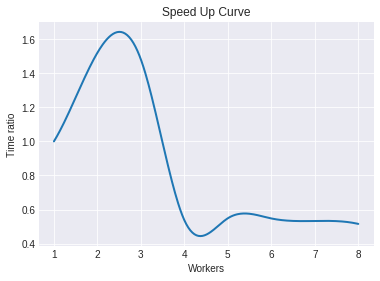

In [48]:
speed_up_curve(time_list, 
               n_folds,
               interpolate=True
              )